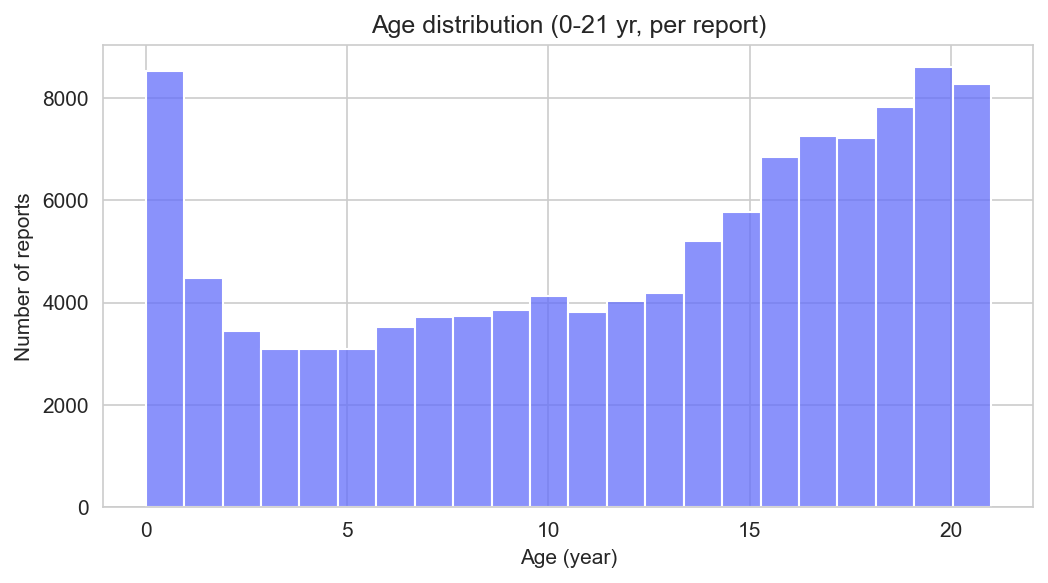

/tmp/ipykernel_32743/3702007253.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rep, x="patient_sex",


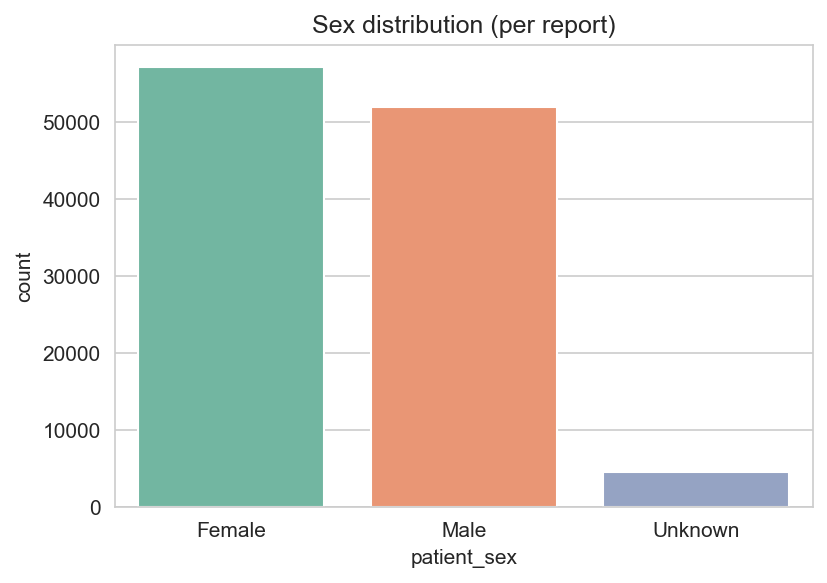

/tmp/ipykernel_32743/3702007253.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rep, y="nichd",


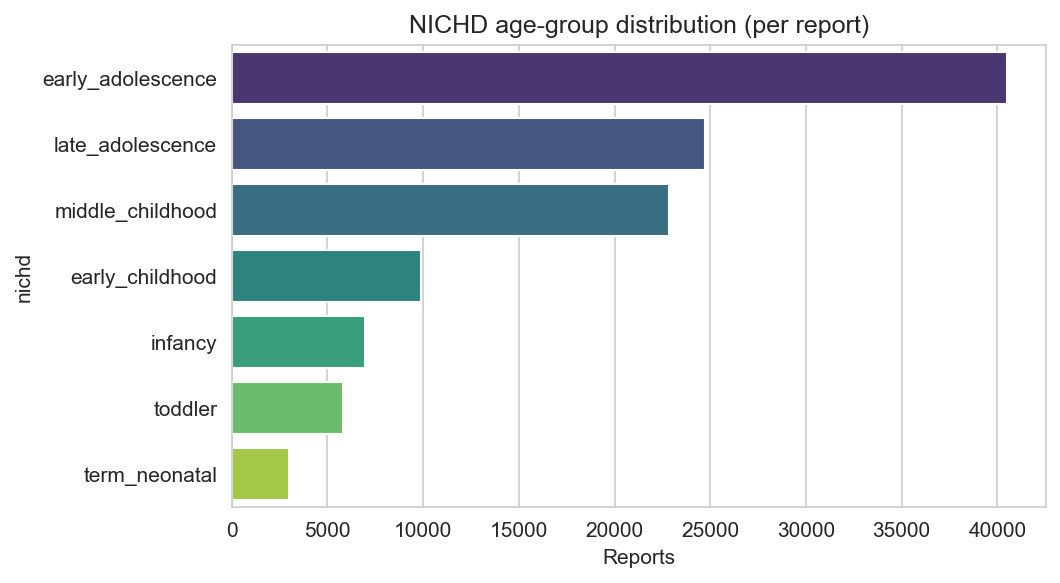

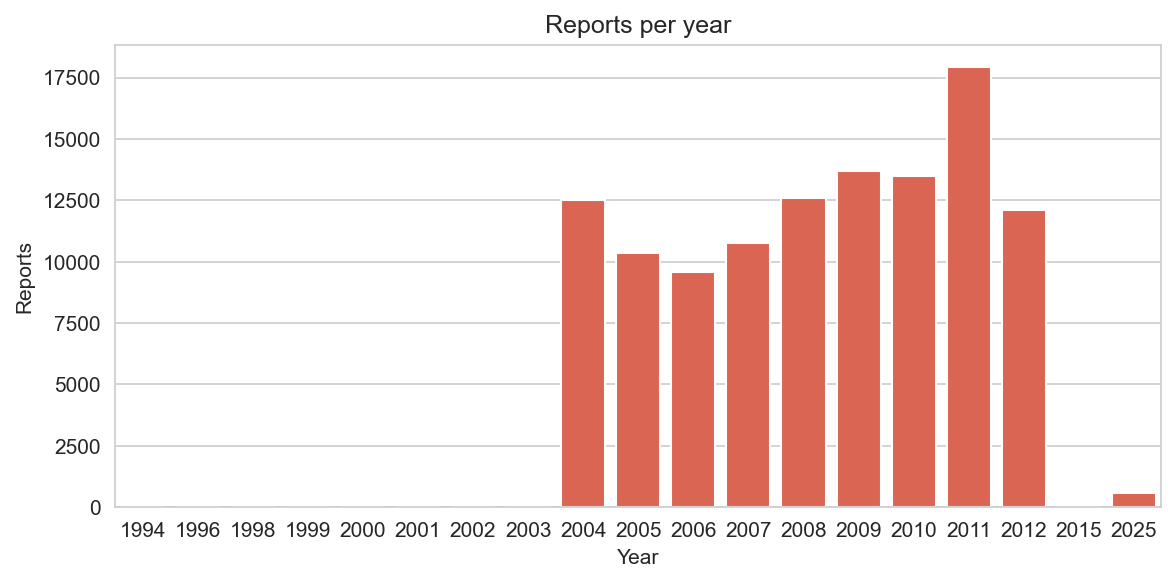

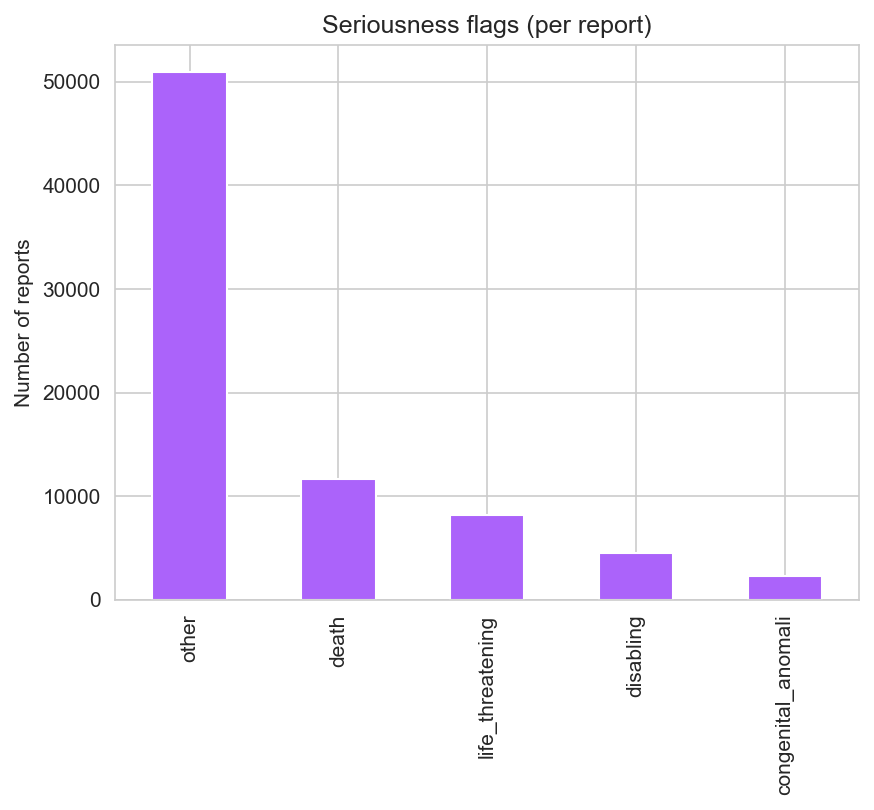

/tmp/ipykernel_32743/3702007253.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_drug.index, x=top_drug.values, palette="rocket")


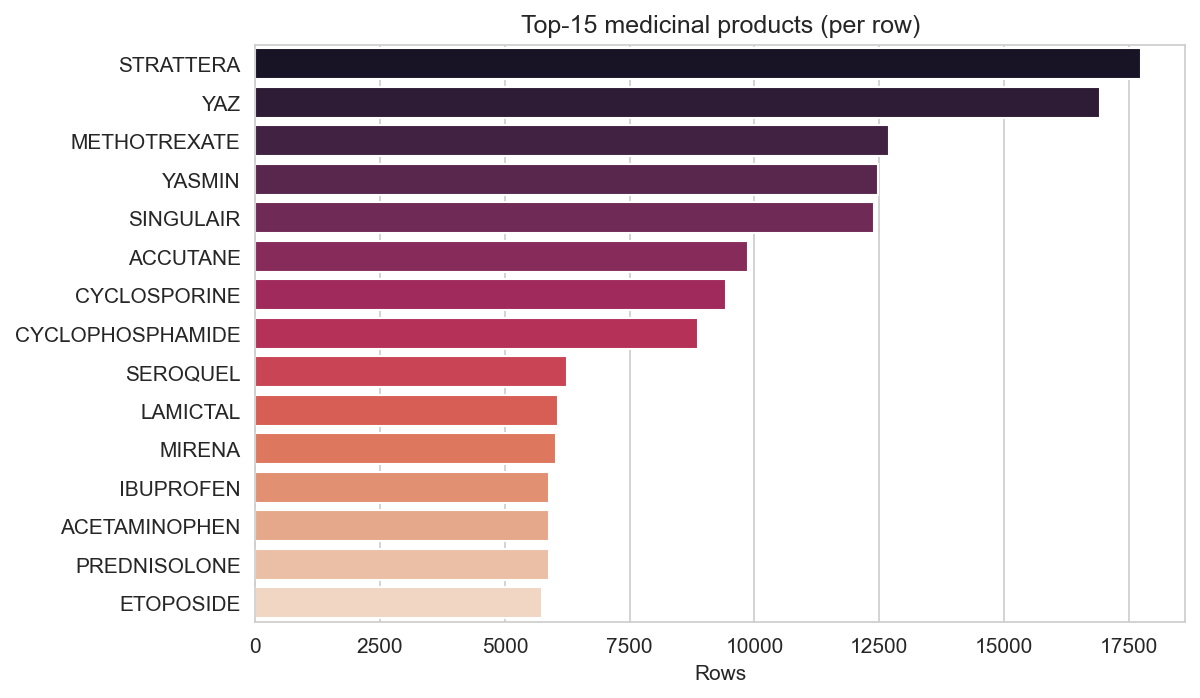

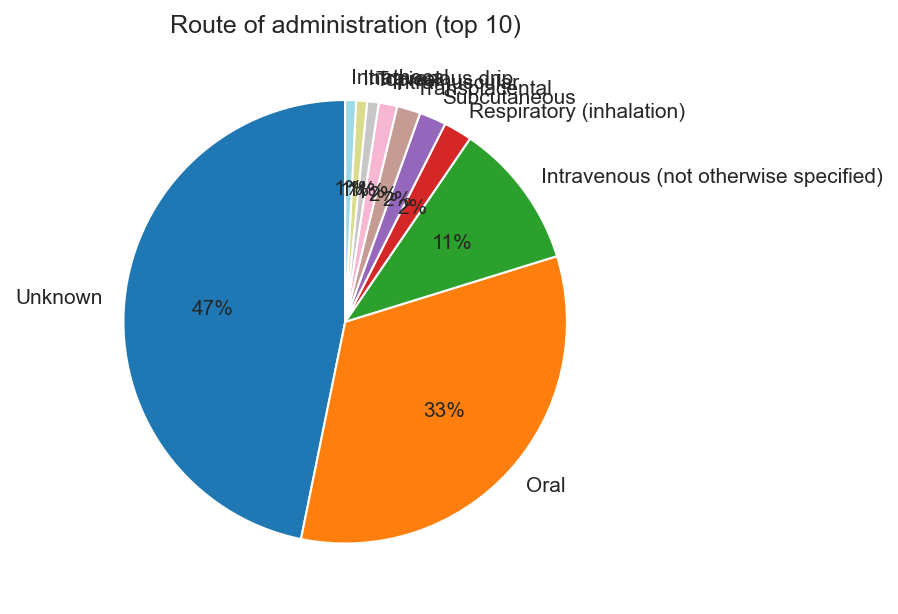

/tmp/ipykernel_32743/3702007253.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_rxn.index, x=top_rxn.values, palette="mako")


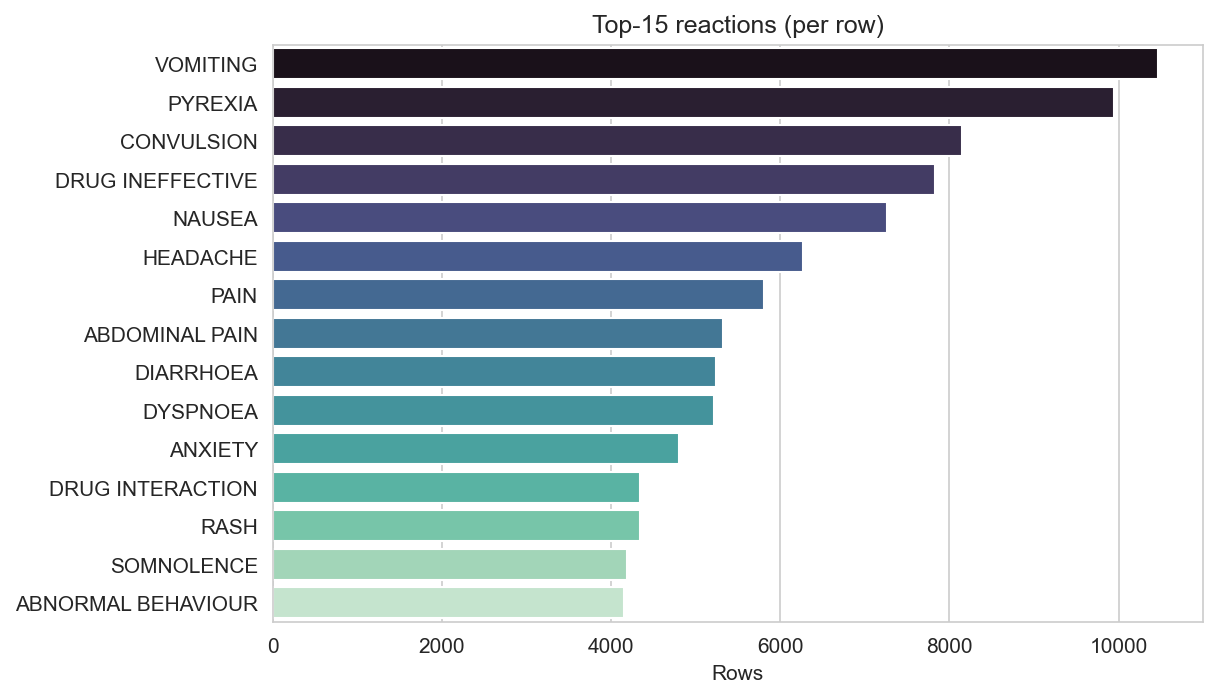

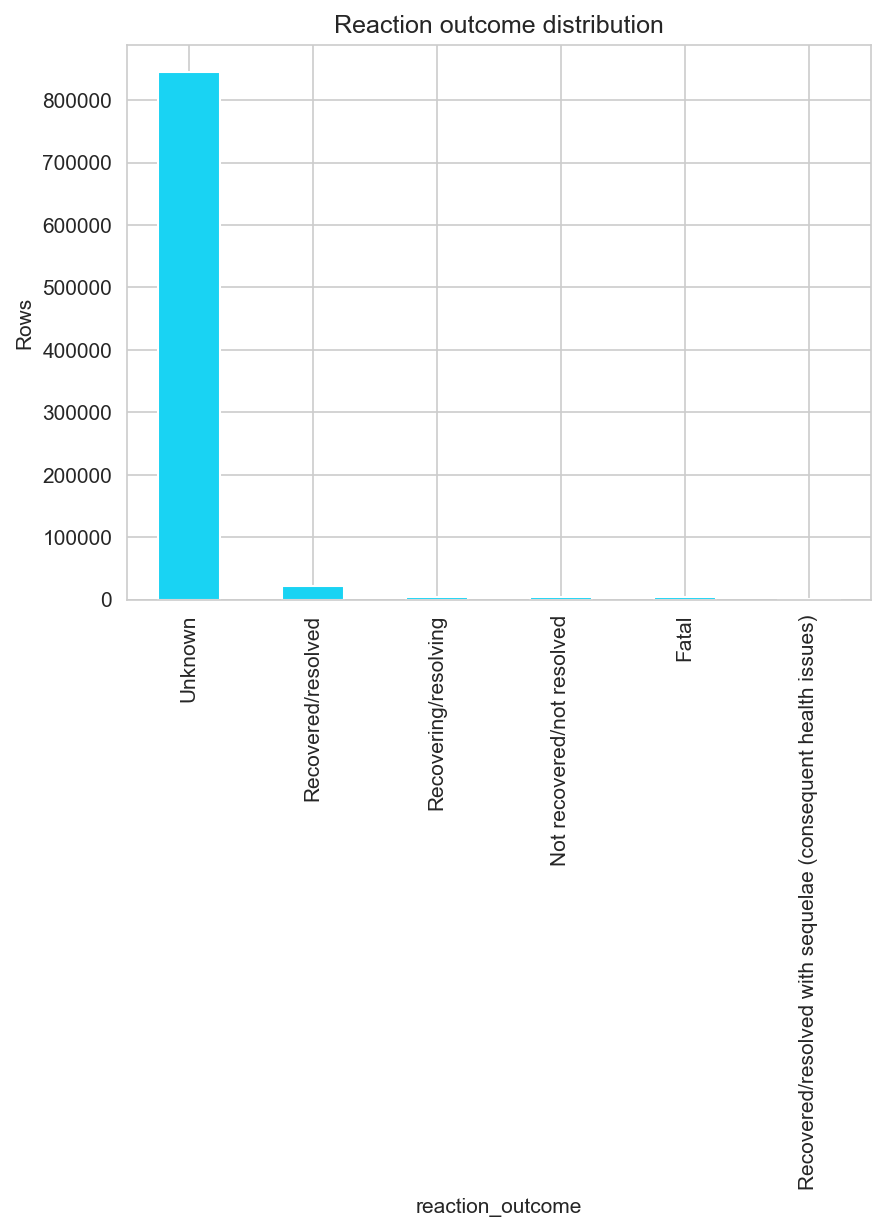

/share/galaxy/thanyathon/miniforge3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8337 (\N{LATIN SUBSCRIPT SMALL LETTER E}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


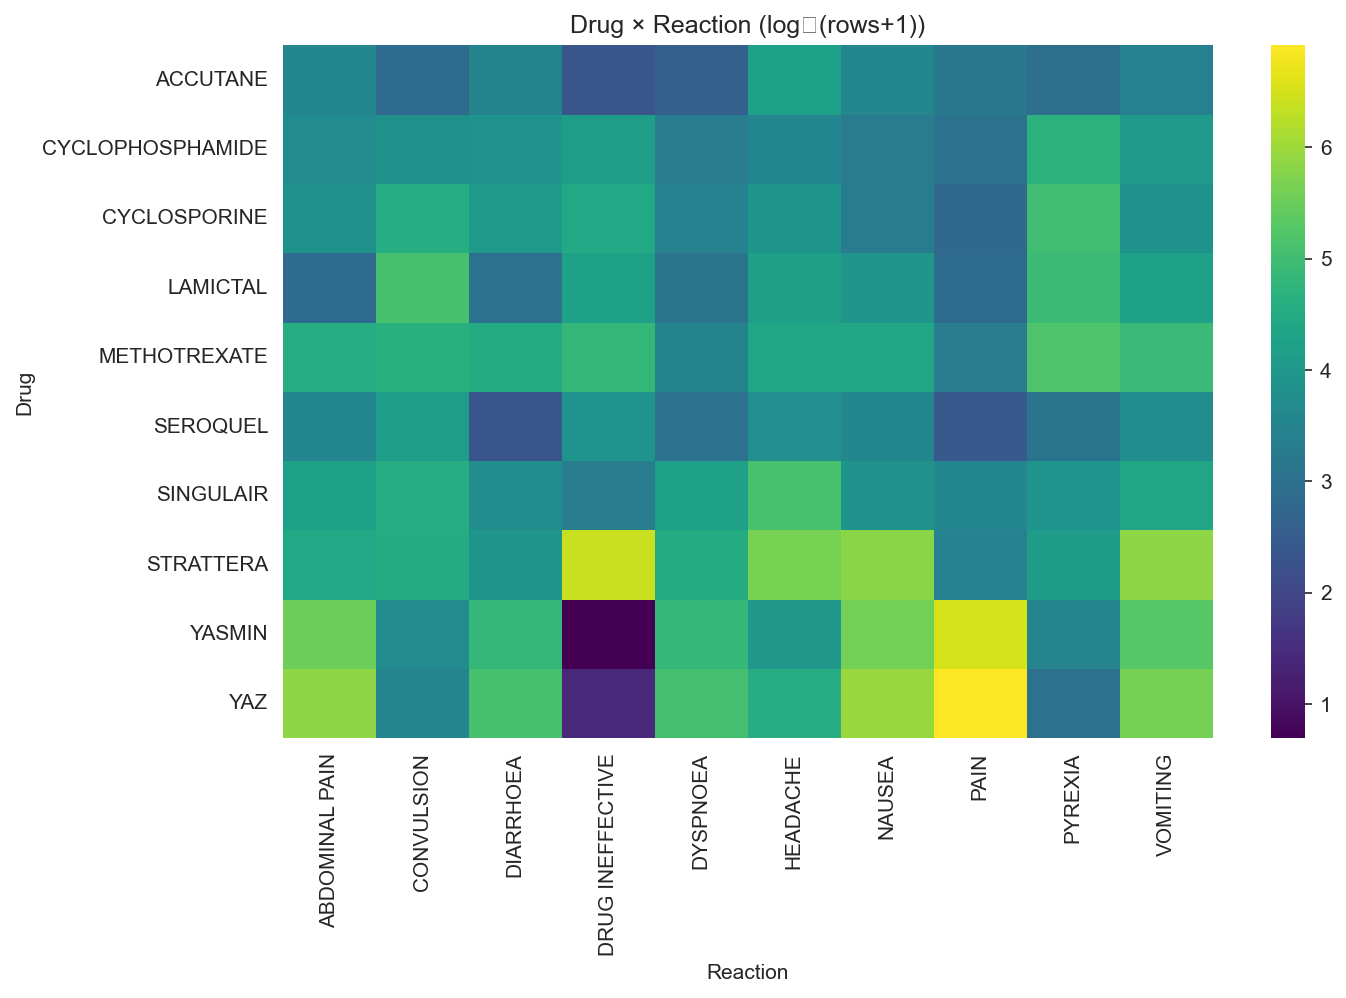

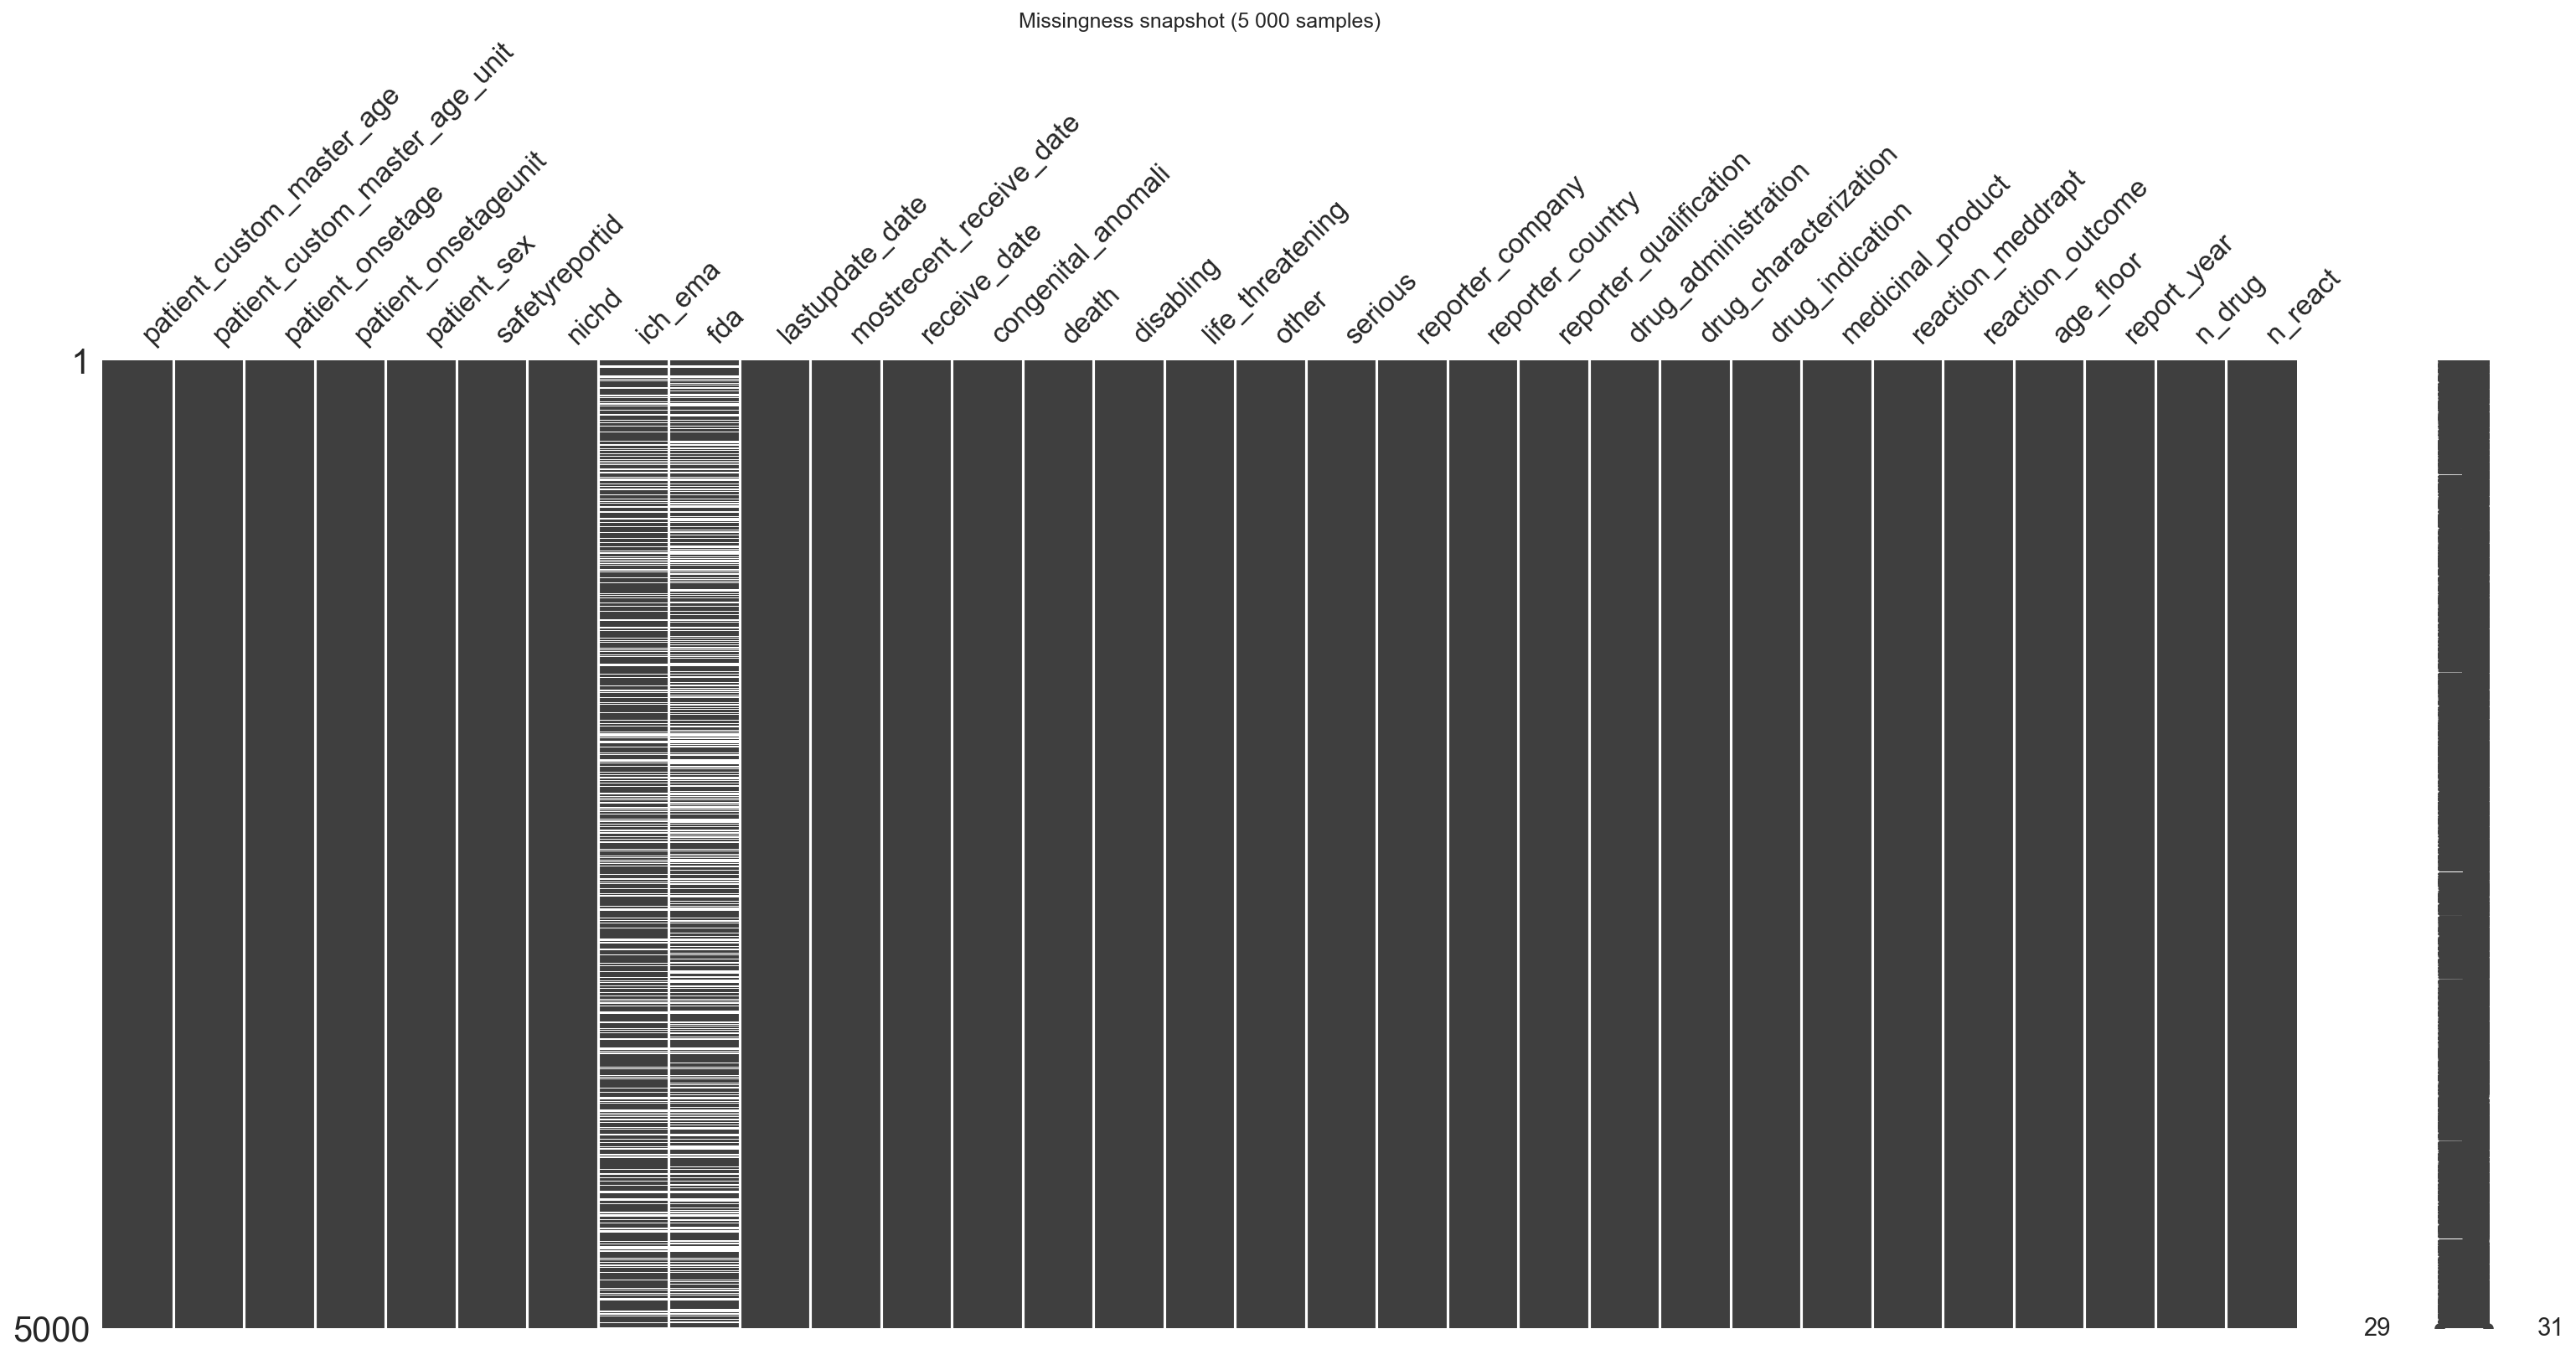

In [3]:
# ──────────────────────────────── 0. SET-UP ────────────────────────────────
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sns.set_style("whitegrid"); plt.rcParams["figure.dpi"] = 150

# ▸ โหลดข้อมูล
# df = pd.read_csv("pediatric_dataset.csv")          # ← เปลี่ยนเป็น path จริง
df = pd.read_csv('../../data/pediatric_patients_report_drug_reaction.csv.gz',compression='gzip', index_col=0)         # ใช้ฟอร์แมตอะไรก็ได้

# ▸ แปลงวันที่ล่วงหน้า  (ใช้ coerce กันหลุด)
for c in ["receive_date","mostrecent_receive_date","lastupdate_date"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# ▸ โต๊ะ “หนึ่งรายงานต่อหนึ่งแถว”
rep = df.drop_duplicates("safetyreportid").copy()

# ──────────────────────────────── 0.1 FEATURE ENGINEERING ──────────────────
# อายุปัดลง & ปีรายงาน
rep["age_floor"]   = np.floor(rep["patient_custom_master_age"])
rep["report_year"] = rep["receive_date"].dt.year

# จำนวนยา / จำนวนอาการต่อรายงาน (ใช้ full df → รวมซ้ำก่อน)
rep["n_drug"]   = df.groupby("safetyreportid")["medicinal_product"].transform("nunique")
rep["n_react"]  = df.groupby("safetyreportid")["reaction_meddrapt"].transform("nunique")

# ──────────────────────────────── 1. PATIENT OVERVIEW ─────────────────────
plt.figure(figsize=(8,4))
sns.histplot(rep, x="age_floor", bins=22, kde=False, color="#636EFA")
plt.title("Age distribution (0-21 yr, per report)")
plt.xlabel("Age (year)"); plt.ylabel("Number of reports")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=rep, x="patient_sex",
              order=rep["patient_sex"].value_counts().index,
              palette="Set2")
plt.title("Sex distribution (per report)"); plt.show()

plt.figure(figsize=(7,4))
sns.countplot(data=rep, y="nichd",
              order=rep["nichd"].value_counts().index,
              palette="viridis")
plt.title("NICHD age-group distribution (per report)"); plt.xlabel("Reports"); plt.show()

# ──────────────────────────────── 2. REPORT OVERVIEW ──────────────────────
plt.figure(figsize=(9,4))
sns.countplot(data=rep, x="report_year", color="#EF553B")
plt.title("Reports per year"); plt.xlabel("Year"); plt.ylabel("Reports"); plt.show()

# bar ความรุนแรง
serious_cols = ["death","life_threatening","disabling",
                "congenital_anomali","other"]  # เพิ่ม/ลดตามจริง
serious_sum = rep[serious_cols].sum().sort_values(ascending=False)
serious_sum.plot(kind="bar", color="#AB63FA")
plt.title("Seriousness flags (per report)"); plt.ylabel("Number of reports"); plt.show()

# ──────────────────────────────── 3. DRUG PROFILE ────────────────────────
topN = 15
top_drug = df["medicinal_product"].value_counts().head(topN)
plt.figure(figsize=(8,5))
sns.barplot(y=top_drug.index, x=top_drug.values, palette="rocket")
plt.title(f"Top-{topN} medicinal products (per row)"); plt.xlabel("Rows"); plt.ylabel("")
plt.show()

route = df["drug_administration"].value_counts().head(10)
route.plot(kind="pie", autopct="%1.0f%%", startangle=90, cmap="tab20")
plt.ylabel(""); plt.title("Route of administration (top 10)"); plt.show()

# ──────────────────────────────── 4. REACTION / OUTCOME ───────────────────
top_rxn = df["reaction_meddrapt"].value_counts().head(topN)
plt.figure(figsize=(8,5))
sns.barplot(y=top_rxn.index, x=top_rxn.values, palette="mako")
plt.title(f"Top-{topN} reactions (per row)"); plt.xlabel("Rows"); plt.ylabel("")
plt.show()

outcome = df["reaction_outcome"].value_counts()
outcome.plot(kind="bar", color="#19D3F3")
plt.title("Reaction outcome distribution"); plt.ylabel("Rows"); plt.show()

# ──────────────────────────────── 5. RELATIONAL HEAT-MAP ──────────────────
# ▸ เลือก Top-10 drug & Top-10 reaction เพื่อไม่ให้แมทริกซ์ใหญ่เกิน
top10_drug  = top_drug.head(10).index
top10_react = top_rxn.head(10).index
pair = df[df["medicinal_product"].isin(top10_drug) &
          df["reaction_meddrapt"].isin(top10_react)]

heat = (pair.groupby(["medicinal_product","reaction_meddrapt"])
             .size().unstack(fill_value=0))

plt.figure(figsize=(10,6))
sns.heatmap(np.log1p(heat), annot=False, cmap="viridis")
plt.title("Drug × Reaction (logₑ(rows+1))")
plt.xlabel("Reaction"); plt.ylabel("Drug")
plt.show()

# ──────────────────────────────── 6. QUICK MISSINGNESS MATRIX ────────────
import missingno as msno
msno.matrix(rep.sample(5000, random_state=1))  # subsample ให้เร็ว
plt.title("Missingness snapshot (5 000 samples)"); plt.show()
